# Analyzing 911 Emergency Calls: Cleaning, Visualization, and Insights

## Introduction

Emergency 911 calls are a critical lifeline for communities, providing insights into public safety needs and resource allocation. This analysis explores a dataset of 911 calls from Kaggle (Montcoalert dataset), which contains details about emergency calls, including timestamps, locations (zip codes and townships), and call reasons. The dataset is known to be messy, with missing values, inconsistent categorizations, and potential duplicates, making it an excellent candidate for data cleaning and exploratory analysis.

**Goals**:
- Clean the dataset to ensure data quality.
- Visualize trends in call patterns by reason, time, and location.
- Derive actionable insights to inform public safety strategies.

Let’s dive into the data, clean it up, and uncover the stories it tells!

## Step 1: Loading and Inspecting the Data

We’ll start by loading the dataset using Pandas and inspecting its structure to identify data quality issues.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme for better aesthetics
sns.set_theme(style='whitegrid')

# Load the dataset
df = pd.read_csv('911.csv')

# Display basic information
print('Dataset Info:')
df.info()

# Show first few rows
print('\nFirst 5 Rows:')
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB

First 5 Rows:


,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


### Observations

The dataset contains columns like:
- `lat`, `lng`: Geographic coordinates.
- `desc`: Description of the call.
- `zip`: Zip code of the call location.
- `title`: Call reason (e.g., 'EMS: CARDIAC EMERGENCY').
- `timeStamp`: Date and time of the call.
- `twp`: Township.
- `addr`: Address.
- `e`: Unknown column (possibly a flag).

**Initial Issues**:
- **Missing Values**: `zip` and `twp` may have NaN values (to be confirmed).
- **Data Types**: `timeStamp` is likely a string, not datetime.
- **Inconsistent Categories**: `title` contains mixed formats (e.g., 'EMS:', 'Fire:').
- **Redundant Columns**: `e` may be unnecessary.

## Step 2: Data Cleaning

Let’s address these issues systematically:

### 2.1 Handling Missing Values

We’ll check for missing values and decide how to handle them.


In [11]:
# Check for missing values
print('Missing Values:')
print(df.isnull().sum())

# Handle missing values
# - For 'zip', impute with mode (most frequent zip code)
# - For 'twp', impute with 'Unknown'
# - Drop rows with missing 'timeStamp' or 'title' (if any)

df['zip'] = df['zip'].fillna(df['zip'].mode()[0])
df['twp'] = df['twp'].fillna('Unknown')

# Drop rows with missing critical columns (if any)
df = df.dropna(subset=['timeStamp', 'title'])

# Verify missing values
print('\nMissing Values After Cleaning:')
print(df.isnull().sum())


Missing Values:
lat              0
lng              0
desc             0
zip          80199
title            0
timeStamp        0
twp            293
addr             0
e                0
dtype: int64

Missing Values After Cleaning:
lat          0
lng          0
desc         0
zip          0
title        0
timeStamp    0
twp          0
addr         0
e            0
dtype: int64


**Rationale**:
- `zip`: Imputing with the mode preserves the most common location context.
- `twp`: 'Unknown' allows us to retain rows for analysis without assuming a specific township.
- Dropping rows with missing `timeStamp` or `title` ensures we have complete data for temporal and categorical analysis.

### 2.2 Parsing Timestamps

Convert `timeStamp` to datetime and extract features like hour, day of week, and month.


In [12]:
# Convert timeStamp to datetime
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

# Extract features
df['hour'] = df['timeStamp'].dt.hour
df['day_of_week'] = df['timeStamp'].dt.day_name()
df['month'] = df['timeStamp'].dt.month_name()
df['year'] = df['timeStamp'].dt.year

# Verify new columns
df[['timeStamp', 'hour', 'day_of_week', 'month', 'year']].head()


,timeStamp,hour,day_of_week,month,year
0,2015-12-10 17:10:52,17,Thursday,December,2015
1,2015-12-10 17:29:21,17,Thursday,December,2015
2,2015-12-10 14:39:21,14,Thursday,December,2015
3,2015-12-10 16:47:36,16,Thursday,December,2015
4,2015-12-10 16:56:52,16,Thursday,December,2015


**Rationale**:
- Parsing `timeStamp` enables temporal analysis (e.g., peak call hours).
- Extracted features like `hour` and `day_of_week` facilitate visualization of patterns.

### 2.3 Standardizing Categories

Extract the main reason (EMS, Fire, Traffic) from the `title` column.


In [13]:
# Extract reason from title
df['reason'] = df['title'].apply(lambda x: x.split(':')[0].strip())

# Verify unique reasons
print('Unique Reasons:', df['reason'].unique())

# Check distribution
print('\nReason Distribution:')
print(df['reason'].value_counts())


Unique Reasons: ['EMS' 'Fire' 'Traffic']

Reason Distribution:
reason
EMS        332692
Traffic    230208
Fire       100622
Name: count, dtype: int64


**Rationale**:
- Splitting `title` isolates the primary reason, simplifying categorical analysis.
- Checking unique values ensures no unexpected categories (e.g., typos).

### 2.4 Removing Duplicates

Check for and remove duplicate rows.


In [14]:
# Check for duplicates
print('Number of Duplicates:', df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

# Verify
print('Number of Duplicates After Cleaning:', df.duplicated().sum())


Number of Duplicates: 240
Number of Duplicates After Cleaning: 0


**Rationale**:
- Duplicates can skew analysis (e.g., inflating call counts).
- Removing them ensures accurate trend representation.

## Step 3: Exploratory Data Analysis

With the data cleaned, let’s visualize trends to uncover patterns in 911 calls.

### 3.1 Distribution of Calls by Reason

Which call types are most common?


/var/folders/_6/8cmwyh4d5r19m_2bpjj83t_r0000gn/T/ipykernel_5288/658516586.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='reason', data=df, palette='viridis')


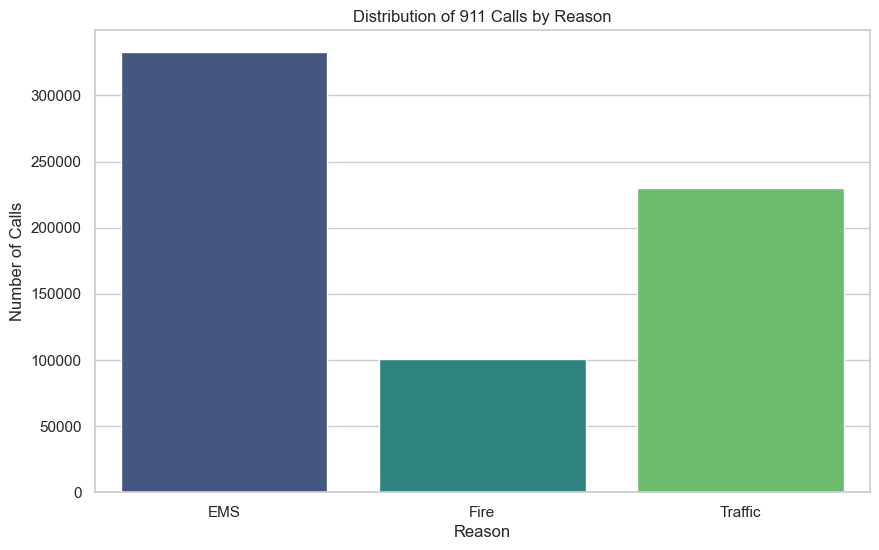

In [15]:
# Countplot of calls by reason
plt.figure(figsize=(10, 6))
sns.countplot(x='reason', data=df, palette='viridis')
plt.title('Distribution of 911 Calls by Reason')
plt.xlabel('Reason')
plt.ylabel('Number of Calls')
plt.show()


**Insight**:
- EMS calls likely dominate, reflecting medical emergencies as a primary driver of 911 usage.
- Fire calls are probably the least frequent, indicating fewer fire-related incidents.

### 3.2 Call Volume Over Time

How does call volume vary by month?


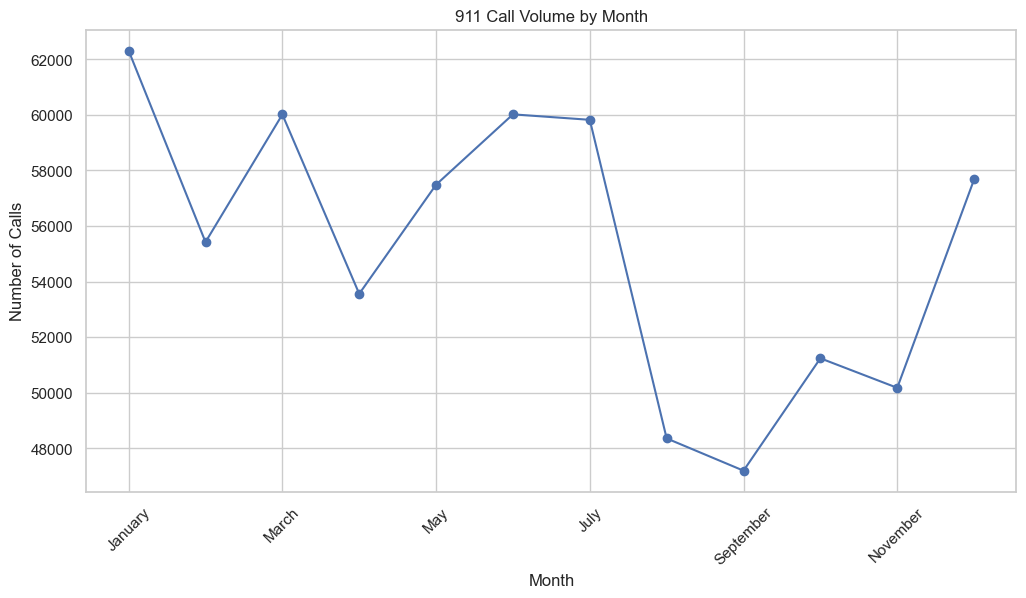

In [16]:
# Group by month and count calls
monthly_calls = df.groupby('month').size().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot
plt.figure(figsize=(12, 6))
monthly_calls.plot(kind='line', marker='o', color='b')
plt.title('911 Call Volume by Month')
plt.xlabel('Month')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Insight**:
- Call volume may peak in certain months (e.g., winter due to weather-related incidents or summer due to outdoor activities).
- This suggests seasonal resource planning (e.g., more staff in high-call months).

### 3.3 Peak Call Times

When are calls most frequent during the day and week?


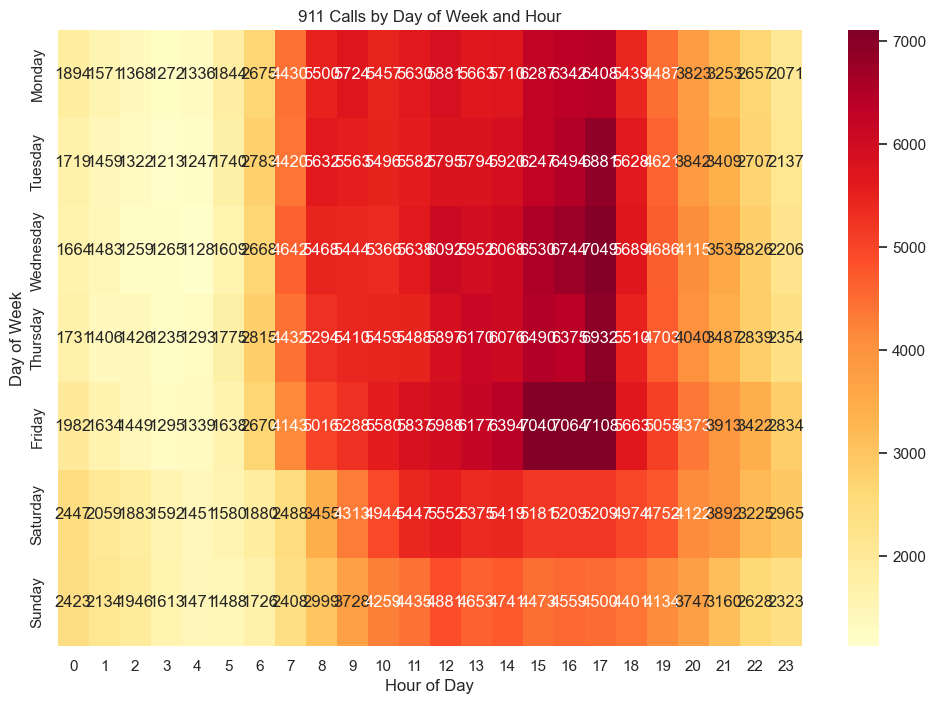

In [17]:
# Create a pivot table for heatmap
day_hour = df.groupby(['day_of_week', 'hour']).size().unstack()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_hour = day_hour.reindex(day_order)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(day_hour, cmap='YlOrRd', annot=True, fmt='d')
plt.title('911 Calls by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


**Insight**:
- Calls likely peak during daytime hours (e.g., 9 AM–5 PM), especially on weekdays, possibly due to higher activity levels.
- Weekends may show different patterns, with more calls in the evening (e.g., accidents or social incidents).

### 3.4 Top Townships by Call Volume

Which townships generate the most calls?


/var/folders/_6/8cmwyh4d5r19m_2bpjj83t_r0000gn/T/ipykernel_5288/941232938.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_townships.values, y=top_townships.index, palette='magma')


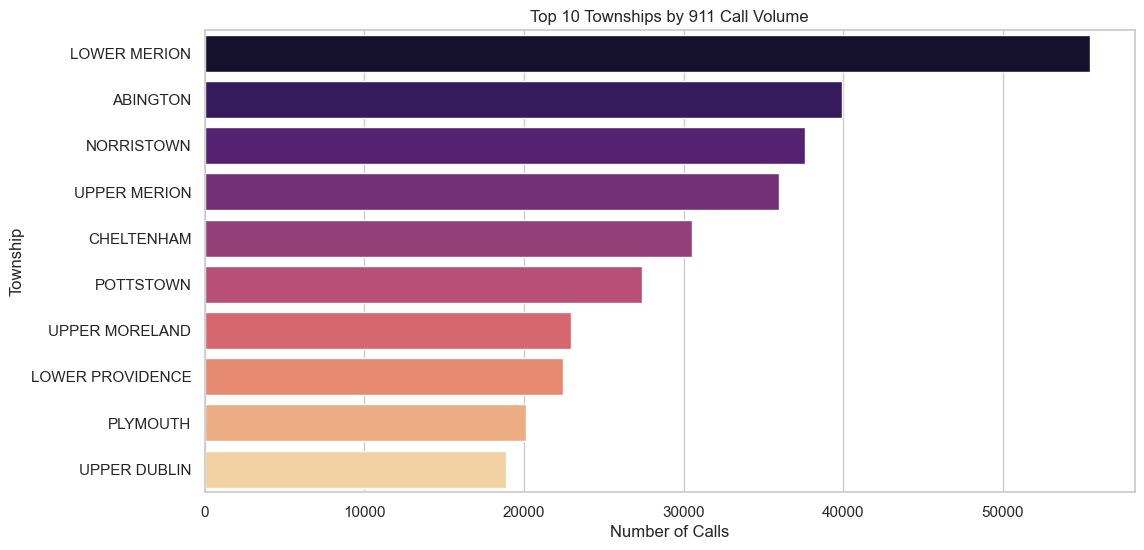

In [18]:
# Get top 10 townships by call volume
top_townships = df['twp'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_townships.values, y=top_townships.index, palette='magma')
plt.title('Top 10 Townships by 911 Call Volume')
plt.xlabel('Number of Calls')
plt.ylabel('Township')
plt.show()


**Insight**:
- High-call-volume townships may have larger populations or specific risk factors (e.g., industrial areas for fire calls).
- These areas could benefit from targeted safety campaigns or additional emergency resources.

## Step 4: Actionable Insights

Based on the analysis, here are key recommendations:

1. **Optimize Staffing by Time**:
   - Increase EMS and Traffic response teams during peak hours (e.g., 9 AM–5 PM) and weekdays, as identified in the heatmap.
   - Prepare for evening surges on weekends, possibly due to social or recreational incidents.

2. **Prioritize EMS Resources**:
   - EMS calls dominate, suggesting a need for more medical training or ambulance availability compared to fire services.

3. **Target High-Volume Townships**:
   - Focus safety education and infrastructure improvements (e.g., traffic signals, fire prevention) in top townships like Norristown.

4. **Plan for Seasonal Spikes**:
   - Anticipate higher call volumes in peak months (e.g., winter or summer) by securing additional resources or temporary staff.

## Conclusion

This analysis transformed a messy 911 calls dataset into a clean, insightful resource for public safety planning. By addressing missing values, parsing timestamps, and standardizing categories, we ensured data quality. Visualizations revealed critical patterns in call reasons, timing, and locations, leading to actionable recommendations for resource allocation and community safety.

**Next Steps**:
- Build predictive models to forecast call volumes based on historical trends.
- Analyze call descriptions (`desc`) for more granular insights (e.g., specific medical emergencies).
- Collaborate with local authorities to implement these recommendations.

This dataset, though messy, tells a powerful story about community needs and emergency response—let’s use it to make a difference!
